In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [26]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # Reverse addition b+a
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other): #reverse multiplicatio b*a
        return self * other
    
    def __sub__(self, other): #a-b
        return self + (-other)
    
    def __rsub__(self, other): #b-a
        return self + (-other)

    def __pow__(self, other): #exponentiation
        assert(isinstance(other, (int,float))) #only can only be int or float
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # a/b
        return self * other**(-1)

    def __neg__(self): #-a
        return self * -1
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def log(self):
        out = Value(math.log(self.data), (self, ), 'log')

        def _backward():
            self.grad += (1 / self.data) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        
        topo = []
        visited =  set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [27]:
a = Value(2)
b = Value(3)
a - b
2* a

Value(data=4)

In [28]:
#Visualization


from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

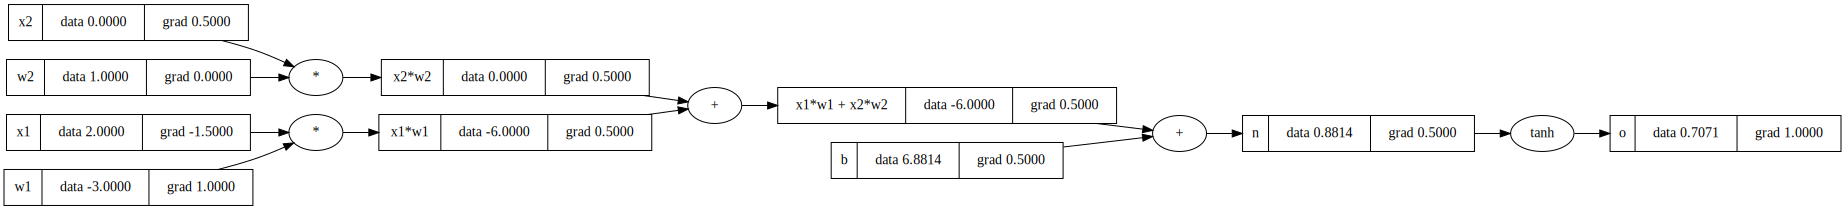

In [30]:
o.backward()
draw_dot(o)

In [31]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'

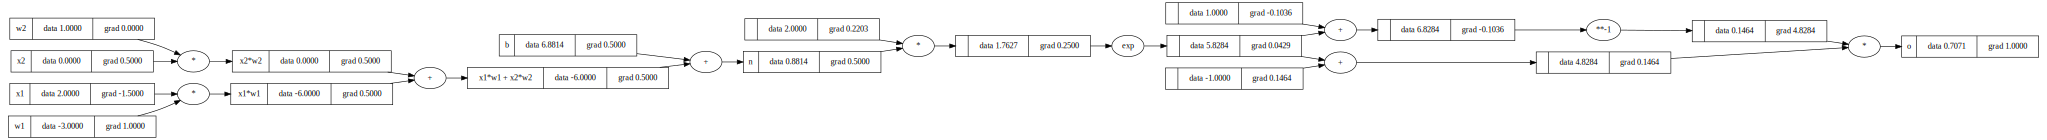

In [32]:
o.backward()
draw_dot(o)

In [33]:
class Neuron:
    def __init__(self, number_of_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout): #takes number of inputs and number of outputs
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:
    def __init__(self, nin, nouts): #takes number of input and list with number of outputs of the different layers
        sz = [nin] + nouts
        self.layers = [Layer((sz[i]), sz[i+1]) for i in range(len(nouts))] #creates layers with given sizes

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [34]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.3898681748443735)

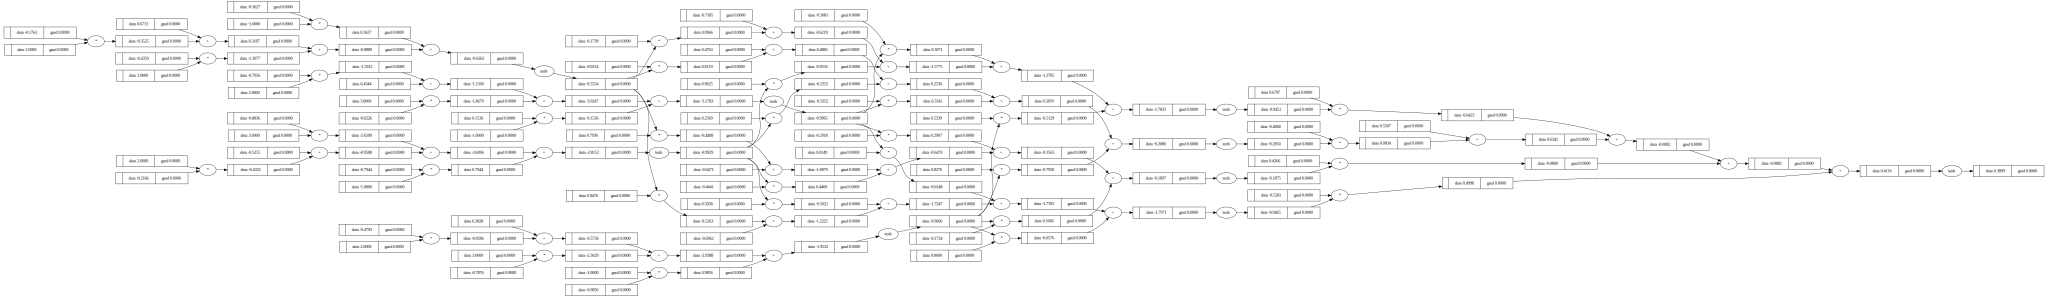

In [35]:
draw_dot(n(x))

In [36]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

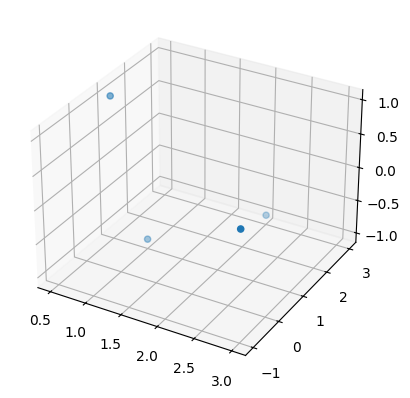

In [37]:
ax = plt.figure().add_subplot(projection = "3d")

ax.scatter([x[0] for x in xs], [x[1] for x in xs], [x[2] for x in xs])

In [38]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)

Value(data=4.941421661223784)


In [39]:
#gradient descent
for k in range(100):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    #parameter update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 4.941421661223784
1 4.714930647426914
2 4.535275788042507
3 4.398028945070769
4 4.293624303393327
5 4.212247578519208
6 4.14607604331397
7 4.089555970947265
8 4.038916894479899
9 3.9916006618718187
10 3.945826269865658
11 3.9003078049773667
12 3.8540859072974225
13 3.8064304342090782
14 3.7567822132093682
15 3.704712140704295
16 3.6498844791433473
17 3.592018807837026
18 3.5308518325152924
19 3.466104892718084
20 3.3974640043823783
21 3.3245766441514135
22 3.247065235639588
23 3.1645539966494325
24 3.0767047092119766
25 2.9832575789174993
26 2.8840743227920616
27 2.7791809056884946
28 2.6688066244942545
29 2.5534148851594773
30 2.4337198107150626
31 2.310682666643218
32 2.1854836979151906
33 2.059468482466368
34 1.9340726719087642
35 1.8107336900748563
36 1.6908010911637505
37 1.5754577921459174
38 1.4656621138066204
39 1.3621162149452237
40 1.2652613892455502
41 1.1752962141291745
42 1.0922107166898978
43 1.0158289033020411
44 0.945852870238967
45 0.8819035614937922
46 0.82355531982

In [40]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(ypred)

[Value(data=0.7996892590920146), Value(data=-0.88870447916035), Value(data=-0.7775660755250379), Value(data=0.8545635528441888)]


Classification: Softmax

In [43]:
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)
print([logits[dim].grad for dim in range(4)])

2.1755153626167147
[0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]


In [42]:
#Confirming grad with Pytorch
import torch
import torch.nn.functional as F

logits = torch.Tensor ([0.0, 3.0, -2.0, 1.0]).double()
logits.requires_grad = True

loss = -F.log_softmax(logits, dim = -1)[3]
print(loss)
loss.backward()

logits.grad

tensor(2.1755, dtype=torch.float64, grad_fn=<NegBackward0>)


tensor([ 0.0418,  0.8390,  0.0057, -0.8865], dtype=torch.float64)